<class 'pandas.core.frame.DataFrame'>
Index: 230736 entries, 230736 to 461471
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      230736 non-null  datetime64[ns]
 1   y       230736 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23741 entries, 0 to 23740
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      23741 non-null  datetime64[ns]
 1   y       23741 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 371.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      228 non-null    datetime64[ns]
 1   y       228 non-null    float64       
dtypes: datetime64[ns](1),

/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_31135/395939822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


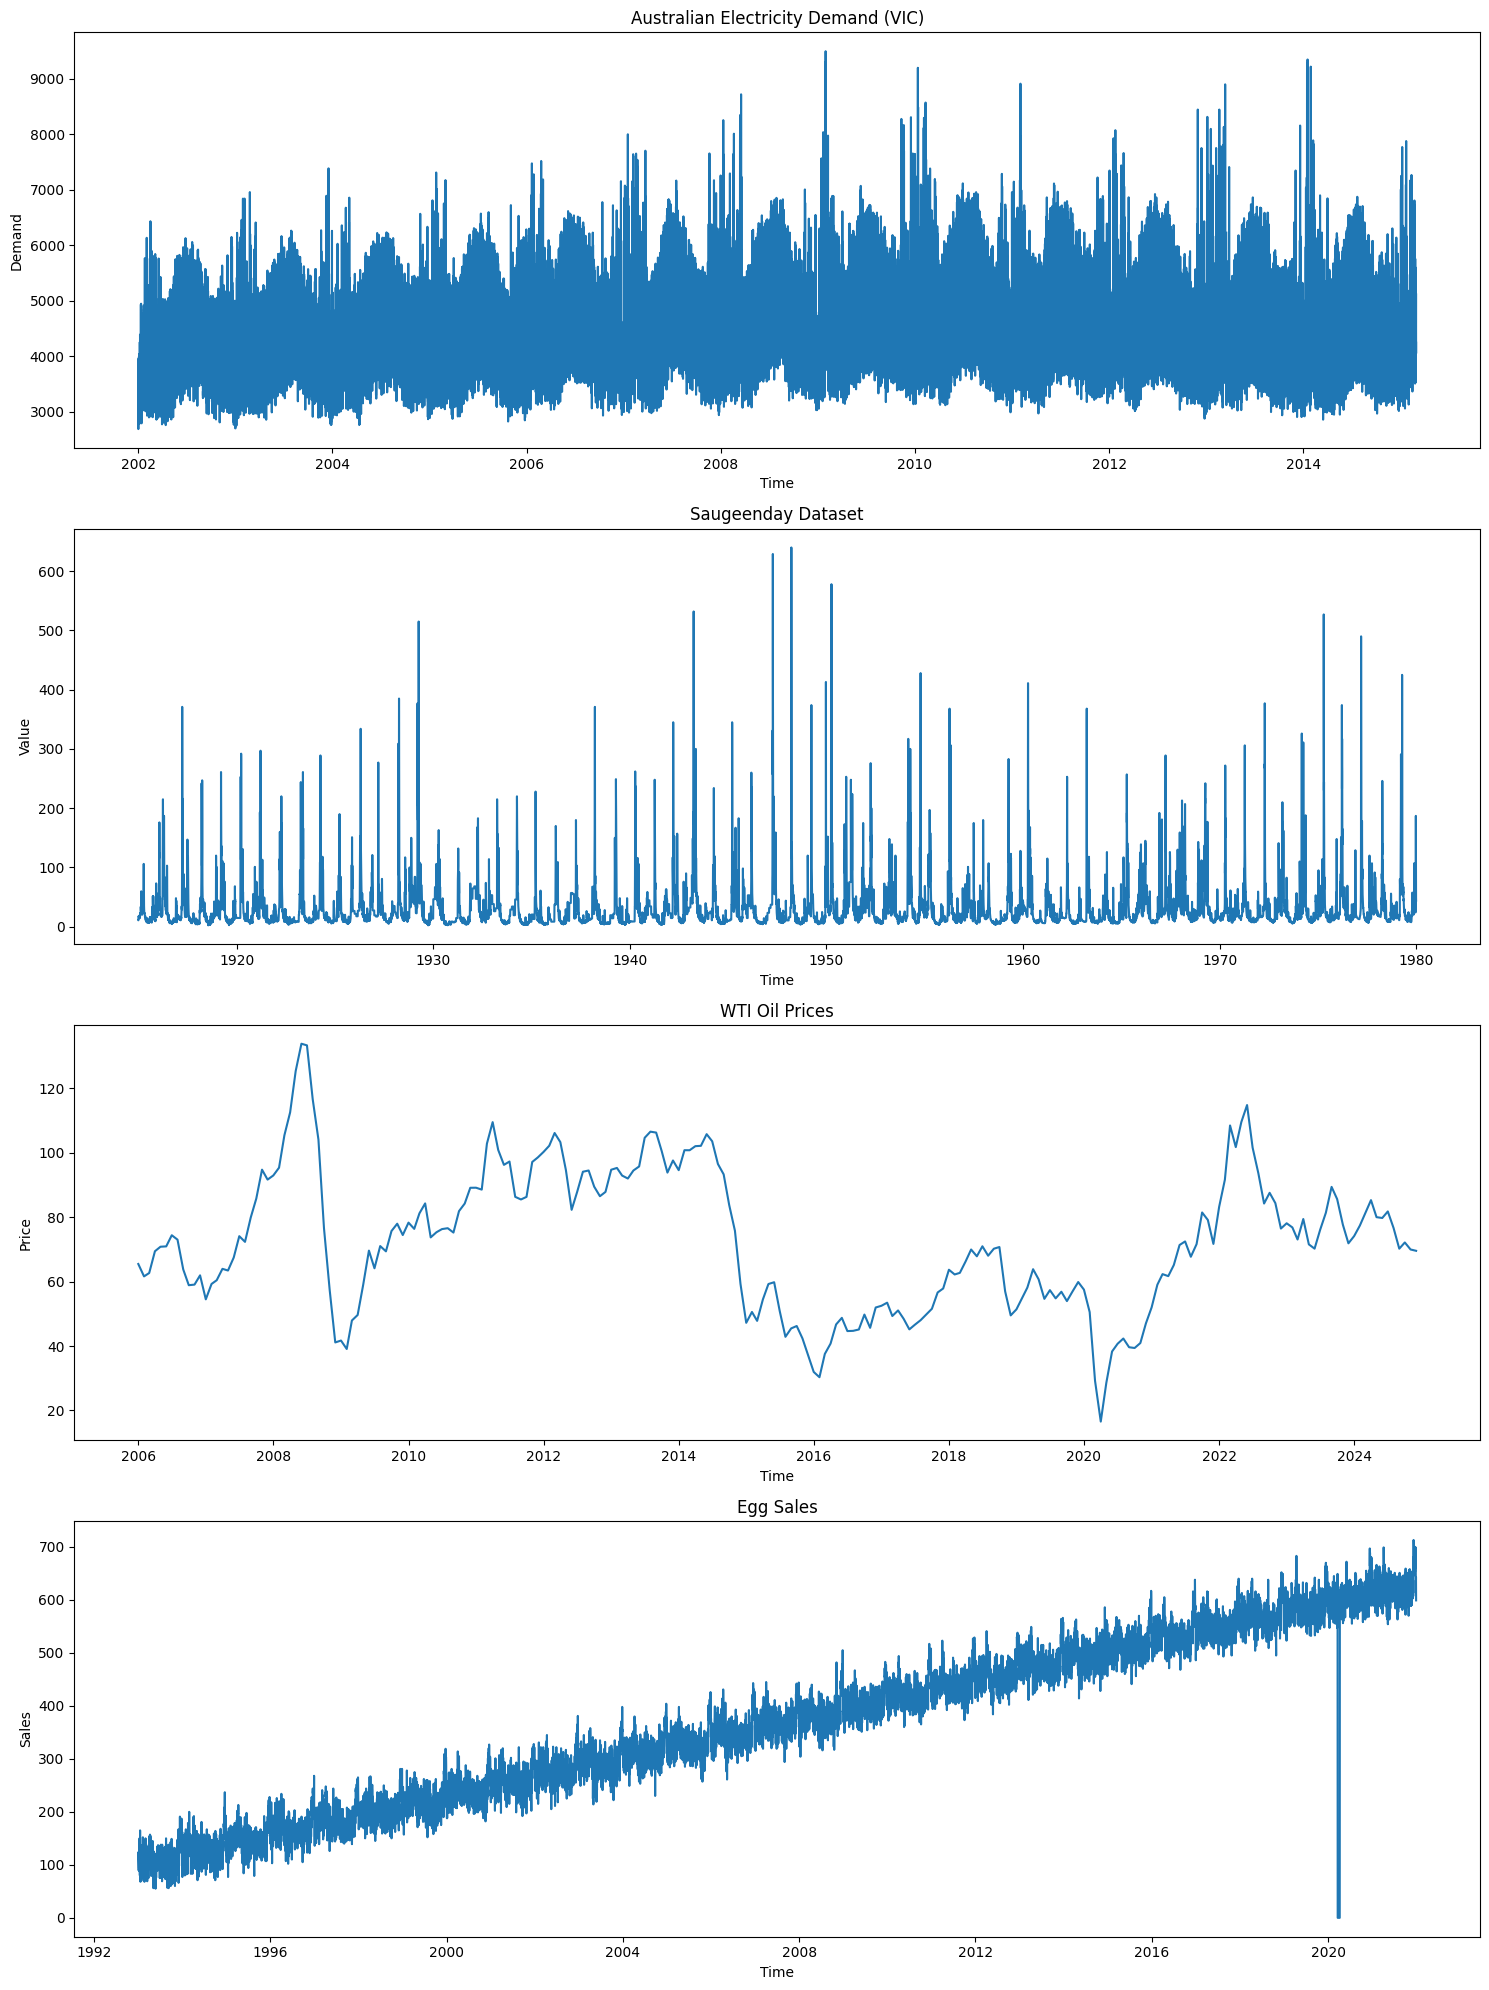

In [72]:
%run 'datagetter.ipynb'

# Baseline

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))



In [102]:
def split_train_test(df, test_size):
    df = df.sort_values('ds').reset_index(drop=True)
    train_size = int(len(df) * (1 - test_size))
    return df.iloc[:train_size], df.iloc[train_size:]

def historical_mean(train, test):
    return np.repeat(train['y'].mean(), len(test))

def last_value(train, test):
    return np.repeat(train['y'].iloc[-1], len(test))

def naive_seasonal(train, test, max_years_back=10):
    td = train.set_index('ds')['y']
    preds = []
    for ds in test['ds']:
        val = np.nan
        for yr in range(1, max_years_back+1):
            prev = ds - pd.DateOffset(years=yr)
            if prev in td.index:
                val = td.loc[prev]
                break
        preds.append(val)
    return preds

def last_year_mean(train, test):
    start = test['ds'].iloc[0] - pd.DateOffset(years=1)
    mask = (train['ds'] >= start) & (train['ds'] < test['ds'].iloc[0])
    if not mask.any():
        return [np.nan]*len(test)
    m = train.loc[mask, 'y'].mean()
    return [m]*len(test)

def plot_baseline_results(df, test_size=0.1):
    train, test = split_train_test(df, test_size)
    results = {
      'Historical Mean': historical_mean(train, test),
      'Last Value'      : last_value(train, test),
      'Naive Seasonal'  : naive_seasonal(train, test),
      'Last Year Mean'  : last_year_mean(train, test),
    }
    actual = test['y'].values
    dates  = test['ds']
    
    # Bar chart of MAPE
    plt.figure(figsize=(8,4))
    plt.bar(results.keys(),
            [mape(actual, preds) for preds in results.values()])
    plt.ylabel('MAPE')
    plt.xticks(rotation=30)
    plt.title('Baseline Model MAPE')
    
    # Time-series plot
    plt.figure(figsize=(10,4))
    plt.plot(df.sort_values('ds')['ds'], df.sort_values('ds')['y'],
             color='gray', alpha=0.4, label='History')
    for name, style in zip(results.keys(),
                           ['--','-.',':','-']):
       plt.plot(dates, results[name], linestyle=style, label=name)
    plt.plot(dates, actual, 'k-', lw=2, label='Actual')
    split_date = test['ds'].iloc[0]
    plt.axvline(split_date, color='tab:red', linestyle='--', label='Train/Test Split')
    plt.legend()
    plt.title('Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()

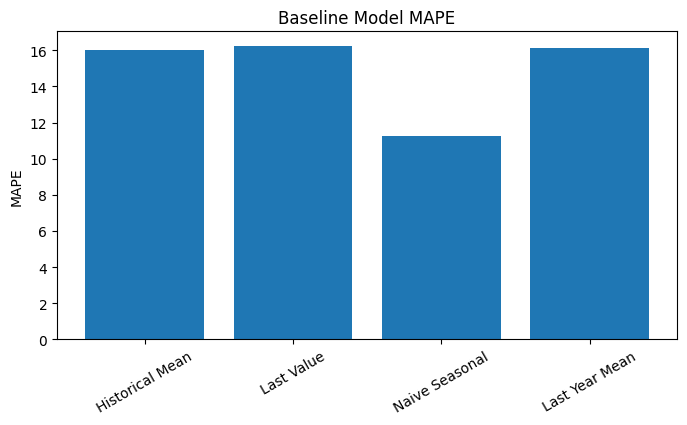

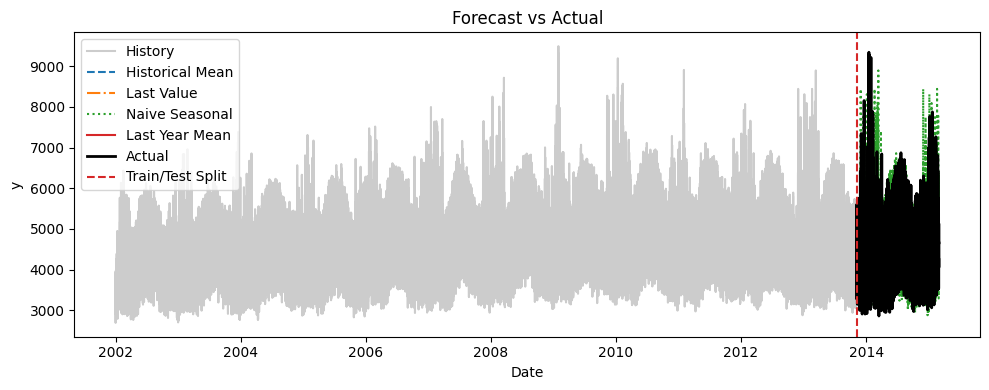

In [103]:
plot_baseline_results(australian_electricity_demand_df)

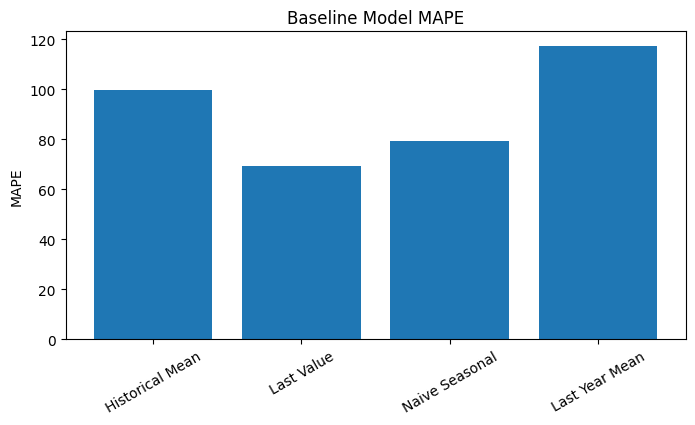

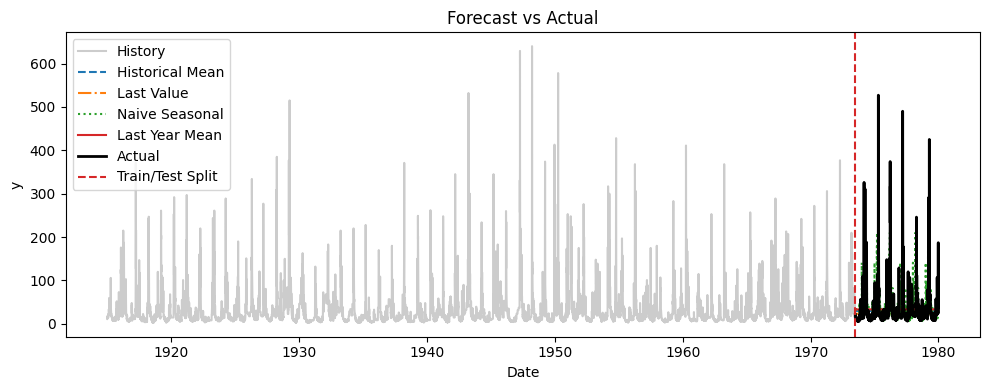

In [104]:
plot_baseline_results(saugeen_river_df)

/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_31135/427435270.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


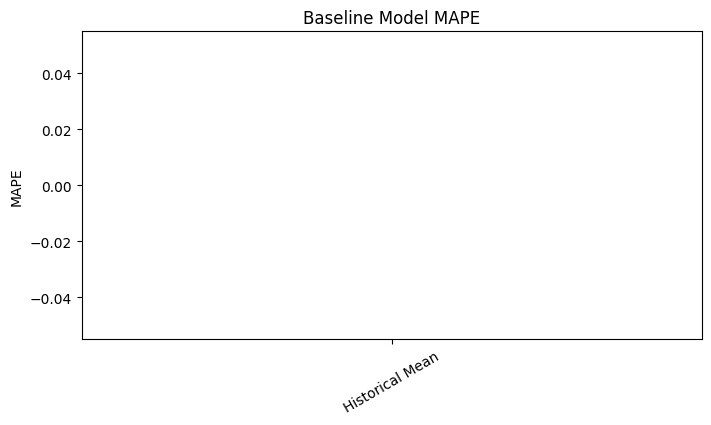

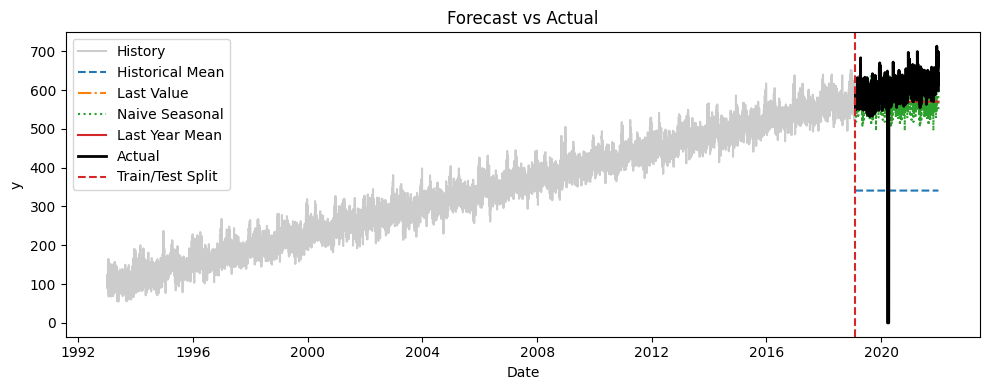

In [105]:
plot_baseline_results(egg_sales_df)

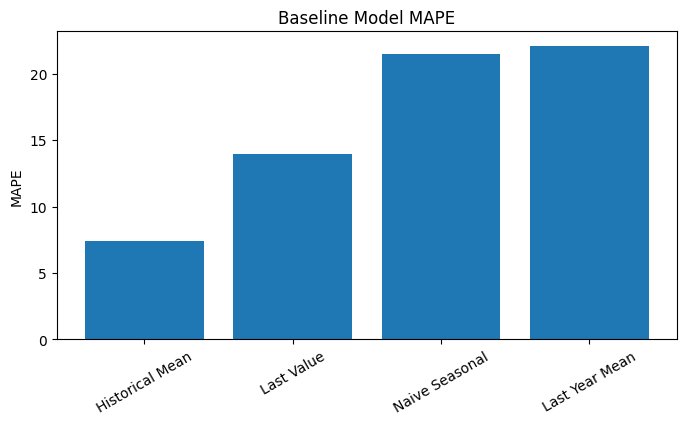

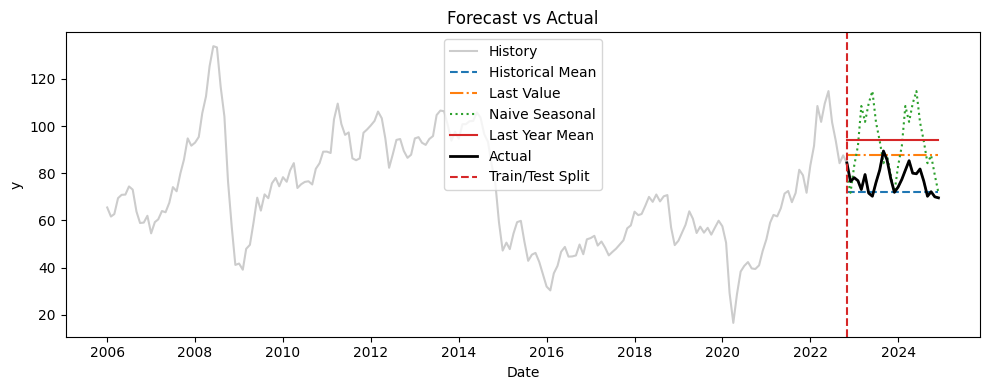

In [106]:
plot_baseline_results(wti_oil_df, test_size=0.11111111)